In [1]:
#-*- coding:utf-8 -*-
import numpy as np
from scipy.io import loadmat, savemat
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU, TimeDistributed, BatchNormalization
from keras.losses import categorical_crossentropy
from keras import regularizers
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical, plot_model
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
import csv
#from imu_preprocess_utils import *
#import tsne as tsne

C:\Users\Zed_Luz\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data input

In [5]:
#%% Import data and save as dict and list
OnlineDatapath = r'C:\Users\Zed_Luz\OneDrive - 南方科技大学\BigScaleFiles\1-datasets for bilateral lower limb neuromechanical signals\2-Data\AB185\Processed\AB185_Circuit_001_post.csv'
data_in = list()
with open(OnlineDatapath) as csvfile:
   spamreader = csv.reader(csvfile)
   for i, row in enumerate(spamreader):
       if i == 0:
           categories = row
       else:
           data_in.append(row)

data_in = np.array(data_in)
data_in_trigger = [row[-8:] for row in data_in] # only trigger 
data_in_notrigger = [row[:-8] for row in data_in] # without trigger 
data_in_notrigger_float = list()
data_in_trigger_float = list()
for i in range(0,len(data_in_notrigger)):
    buff = np.float32(data_in_notrigger[i])
    data_in_notrigger_float.append(buff)
## transfer trigger data into float
#for i in range(0,len(data_in_trigger)):
#    buff = np.float32(data_in_trigger[i])
#    data_in_trigger_float.append(buff)
array_data_in_notrigger_float = np.array(data_in_notrigger_float)
rowcount = array_data_in_notrigger_float.shape[0]
colcount = array_data_in_notrigger_float.shape[1]
dict_data_in = dict()
for col in range(0,colcount):
    dict_data_in[categories[col]] = array_data_in_notrigger_float[:,col]

## Select data in

In [7]:
print(len(categories),'All of Data types:',categories)
selectedchannels = [categories[0], categories[]]

61 All of Data types: ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx', 'Right_TA', 'Right_MG', 'Right_SOL', 'Right_BF', 'Right_ST', 'Right_VL', 'Right_RF', 'Left_TA', 'Left_MG', 'Left_SOL', 'Left_BF', 'Left_ST', 'Left_VL', 'Left_RF', 'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 'Right_Ankle_Velocity', 'Right_Knee_Velocity', 'Left_Ankle_Velocity', 'Left_Knee_Velocity', 'Mode', 'Right_Heel_Contact', 'Right_Heel_Contact_Trigger', 'Right_Toe_Off', 'Right_Toe_Off_Trigger', 'Left_Heel_Contact', 'Left_Heel_Contact_Trigger', 'Left_Toe_Off', 'Left_

## Display data

61 Data types: ['Right_Shank_Ax', 'Right_Shank_Ay', 'Right_Shank_Az', 'Right_Shank_Gy', 'Right_Shank_Gz', 'Right_Shank_Gx', 'Right_Thigh_Ax', 'Right_Thigh_Ay', 'Right_Thigh_Az', 'Right_Thigh_Gy', 'Right_Thigh_Gz', 'Right_Thigh_Gx', 'Left_Shank_Ax', 'Left_Shank_Ay', 'Left_Shank_Az', 'Left_Shank_Gy', 'Left_Shank_Gz', 'Left_Shank_Gx', 'Left_Thigh_Ax', 'Left_Thigh_Ay', 'Left_Thigh_Az', 'Left_Thigh_Gy', 'Left_Thigh_Gz', 'Left_Thigh_Gx', 'Waist_Ax', 'Waist_Ay', 'Waist_Az', 'Waist_Gy', 'Waist_Gz', 'Waist_Gx', 'Right_TA', 'Right_MG', 'Right_SOL', 'Right_BF', 'Right_ST', 'Right_VL', 'Right_RF', 'Left_TA', 'Left_MG', 'Left_SOL', 'Left_BF', 'Left_ST', 'Left_VL', 'Left_RF', 'Right_Ankle', 'Right_Knee', 'Left_Ankle', 'Left_Knee', 'Right_Ankle_Velocity', 'Right_Knee_Velocity', 'Left_Ankle_Velocity', 'Left_Knee_Velocity', 'Mode', 'Right_Heel_Contact', 'Right_Heel_Contact_Trigger', 'Right_Toe_Off', 'Right_Toe_Off_Trigger', 'Left_Heel_Contact', 'Left_Heel_Contact_Trigger', 'Left_Toe_Off', 'Left_Toe_Off

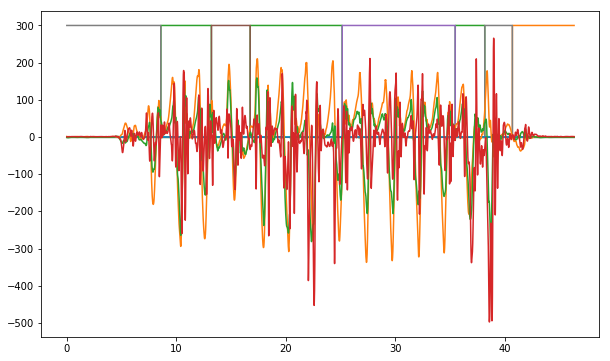

In [3]:
label = dict_data_in['Mode']
label_prep = to_categorical(label)
exp_dur = rowcount/500 # sample rate: 500Hz
nfeat = array_data_in_notrigger_float.shape[1]
t = np.linspace(0, exp_dur, rowcount)
plt.figure(figsize=(10, 6))
#plt.plot(t, label)
plt.plot(t, dict_data_in[categories[0]])
plt.plot(t, label_prep*300)
plt.plot(t, array_data_in_notrigger_float[:,0:6])
plt.show()

## First Model-Regression

In [35]:
lr_model = Sequential()
lr_model.add(Dense(32, input_dim=nfeat, activation='relu'))
lr_model.add(Dense(label_prep.shape[1]))
lr_model.add(Activation('softmax'))
lr_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
lr_model.fit(array_data_in_notrigger_float, label_prep, validation_split=0.33, epochs=30, batch_size=64)

Train on 15517 samples, validate on 7643 samples
Epoch 1/30
15517/15517 [==============================] - 1s 45us/step - loss: 5.1408 - acc: 0.6189 - val_loss: 9.8870 - val_acc: 0.3185
Epoch 2/30
15517/15517 [==============================] - 0s 15us/step - loss: 1.3656 - acc: 0.8763 - val_loss: 9.0550 - val_acc: 0.3694
Epoch 3/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.5726 - acc: 0.9484 - val_loss: 8.8411 - val_acc: 0.3848
Epoch 4/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.4362 - acc: 0.9645 - val_loss: 9.0103 - val_acc: 0.3755
Epoch 5/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.2799 - acc: 0.9803 - val_loss: 9.0575 - val_acc: 0.3760
Epoch 6/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.1926 - acc: 0.9848 - val_loss: 8.9763 - val_acc: 0.3734
Epoch 7/30
15517/15517 [==============================] - 0s 16us/step - loss: 0.0771 - acc: 0.9910 - val_loss: 8.9016 - val_acc:

# Second Model-Regression

In [27]:
lr_model1 = Sequential()
lr_model1.add(Dense(32, input_dim=nfeat, activation='relu'))
lr_model1.add(Dense(label_prep.shape[1]))
lr_model1.add(Activation('softmax'))
lr_model1.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
lr_model1.fit(array_data_in_notrigger_float, label_prep, validation_split=0.33, epochs=30, batch_size=64)

Train on 15517 samples, validate on 7643 samples
Epoch 1/30
15517/15517 [==============================] - 1s 34us/step - loss: 9.3244 - acc: 0.3835 - val_loss: 11.1903 - val_acc: 0.2752
Epoch 2/30
15517/15517 [==============================] - 0s 15us/step - loss: 3.3483 - acc: 0.7510 - val_loss: 10.5959 - val_acc: 0.3064
Epoch 3/30
15517/15517 [==============================] - 0s 14us/step - loss: 1.1067 - acc: 0.9137 - val_loss: 10.1568 - val_acc: 0.3243
Epoch 4/30
15517/15517 [==============================] - 0s 14us/step - loss: 0.6373 - acc: 0.9424 - val_loss: 9.7897 - val_acc: 0.3386
Epoch 5/30
15517/15517 [==============================] - 0s 14us/step - loss: 0.2171 - acc: 0.9783 - val_loss: 9.1585 - val_acc: 0.3732
Epoch 6/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.0620 - acc: 0.9921 - val_loss: 9.3192 - val_acc: 0.3674
Epoch 7/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.0169 - acc: 0.9977 - val_loss: 9.7906 - val_a

## Third Model-Regression

In [28]:
lr_model2 = Sequential()
lr_model2.add(Dense(32, input_dim=nfeat, activation='sigm`oid'))
lr_model2.add(Dense(label_prep.shape[1]))
lr_model2.add(Activation('softmax'))
lr_model2.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
lr_model2.fit(array_data_in_notrigger_float, label_prep, validation_split=0.33, epochs=30, batch_size=64)

Train on 15517 samples, validate on 7643 samples
Epoch 1/30
15517/15517 [==============================] - 1s 38us/step - loss: 1.2826 - acc: 0.5064 - val_loss: 2.2844 - val_acc: 0.2223
Epoch 2/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.6745 - acc: 0.7673 - val_loss: 2.7876 - val_acc: 0.2591
Epoch 3/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.5016 - acc: 0.8355 - val_loss: 3.2625 - val_acc: 0.2873
Epoch 4/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.3840 - acc: 0.8946 - val_loss: 3.5118 - val_acc: 0.3105
Epoch 5/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.2980 - acc: 0.9426 - val_loss: 3.8065 - val_acc: 0.3283
Epoch 6/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.2348 - acc: 0.9656 - val_loss: 4.0246 - val_acc: 0.3346
Epoch 7/30
15517/15517 [==============================] - 0s 15us/step - loss: 0.1872 - acc: 0.9782 - val_loss: 4.2059 - val_acc:

## Plot-1st Model-Regression

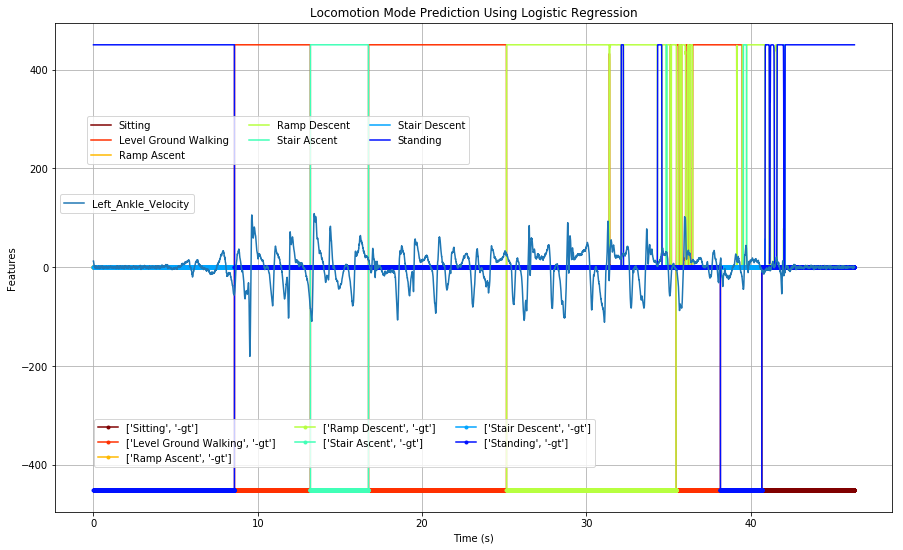

In [31]:
#%%
preds = lr_model.predict(array_data_in_notrigger_float)
labelcategories = ['Sitting','Level Ground Walking','Ramp Ascent','Ramp Descent','Stair Ascent','Stair Descent','Standing']
#print(preds)
plt.figure(figsize=(15, 9))
cmap = plt.get_cmap('jet_r')
labelpreds0, = plt.plot(t, preds[:, 0]*450, label=labelcategories[0], color = cmap(0/len(labelcategories)))
labelpreds1, = plt.plot(t, preds[:, 1]*450, label=labelcategories[1], color = cmap(1/len(labelcategories)))
labelpreds2, = plt.plot(t, preds[:, 2]*450, label=labelcategories[2], color = cmap(2/len(labelcategories)))
labelpreds3, = plt.plot(t, preds[:, 3]*450, label=labelcategories[3], color = cmap(3/len(labelcategories)))
labelpreds4, = plt.plot(t, preds[:, 4]*450, label=labelcategories[4], color = cmap(4/len(labelcategories)))
labelpreds5, = plt.plot(t, preds[:, 5]*450, label=labelcategories[5], color = cmap(5/len(labelcategories)))
labelpreds6, = plt.plot(t, preds[:, 6]*450, label=labelcategories[6], color = cmap(6/len(labelcategories)))
labelgt0, = plt.plot(t, label_prep[:, 0]*(-450),marker='.', label=[labelcategories[0],'-gt'], color = cmap(0/len(labelcategories)))
labelgt1, = plt.plot(t, label_prep[:, 1]*(-450),marker='.', label=[labelcategories[1],'-gt'], color = cmap(1/len(labelcategories)))
labelgt2, = plt.plot(t, label_prep[:, 2]*(-450),marker='.', label=[labelcategories[2],'-gt'], color = cmap(2/len(labelcategories)))
labelgt3, = plt.plot(t, label_prep[:, 3]*(-450),marker='.', label=[labelcategories[3],'-gt'], color = cmap(3/len(labelcategories)))
labelgt4, = plt.plot(t, label_prep[:, 4]*(-450),marker='.', label=[labelcategories[4],'-gt'], color = cmap(4/len(labelcategories)))
labelgt5, = plt.plot(t, label_prep[:, 5]*(-450),marker='.', label=[labelcategories[5],'-gt'], color = cmap(5/len(labelcategories)))
labelgt6, = plt.plot(t, label_prep[:, 6]*(-450),marker='.', label=[labelcategories[6],'-gt'], color = cmap(6/len(labelcategories)))

firstlegend = plt.legend(handles=[labelpreds0,labelpreds1,labelpreds2,labelpreds3,labelpreds4,labelpreds5,labelpreds6],
                         bbox_to_anchor=(0.5,0.7),ncol=3)
ax = plt.gca().add_artist(firstlegend)
secondlegend = plt.legend(handles=[labelgt0,labelgt1, labelgt2, labelgt3, labelgt4, labelgt5, labelgt6],
                          bbox_to_anchor=(0.65,0.2),ncol=3)
ax = plt.gca().add_artist(secondlegend)
#labelpreds, = plt.plot(t, label_prep*4)
data1, = plt.plot(t, array_data_in_notrigger_float[:,-2-1], label=categories[-2-1-8])
#plt.plot(t, array_data_in_notrigger_float[:,1], label=categories[1])
#plt.plot(t, array_data_in_notrigger_float[:,2], label=categories[2])
plt.legend(handles=[data1],bbox_to_anchor=(0,0.6,1, 0.4) )
#plt.xlim([26, 46])
#plt.ylim([-50, 50])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.title('Locomotion Mode Prediction Using Logistic Regression')
plt.grid()
plt.show()

## Plot-2nd Model-Regression

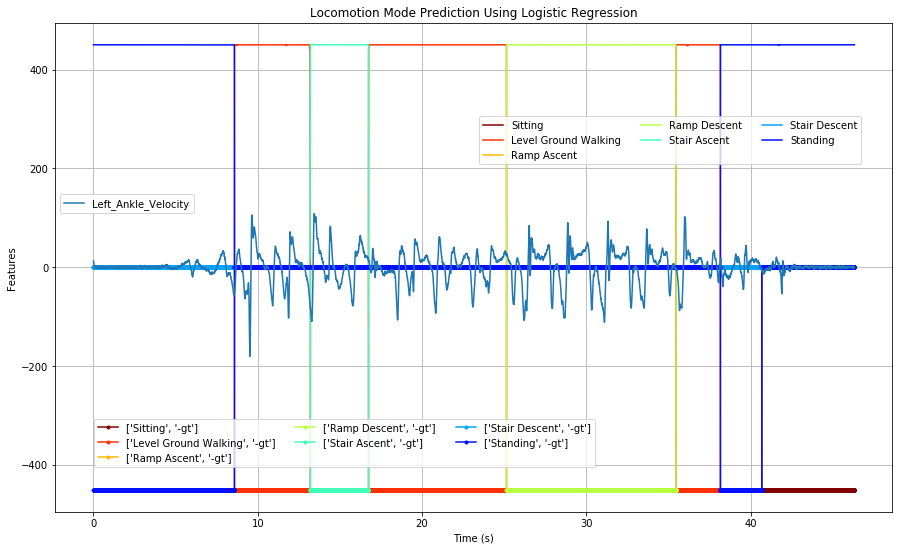

In [15]:
#%%
preds = lr_model1.predict(array_data_in_notrigger_float)
labelcategories = ['Sitting','Level Ground Walking','Ramp Ascent','Ramp Descent','Stair Ascent','Stair Descent','Standing']
#print(preds)-Regression
plt.figure(figsize=(15, 9))
cmap = plt.get_cmap('jet_r')
labelpreds0, = plt.plot(t, preds[:, 0]*450, label=labelcategories[0], color = cmap(0/len(labelcategories)))
labelpreds1, = plt.plot(t, preds[:, 1]*450, label=labelcategories[1], color = cmap(1/len(labelcategories)))
labelpreds2, = plt.plot(t, preds[:, 2]*450, label=labelcategories[2], color = cmap(2/len(labelcategories)))
labelpreds3, = plt.plot(t, preds[:, 3]*450, label=labelcategories[3], color = cmap(3/len(labelcategories)))
labelpreds4, = plt.plot(t, preds[:, 4]*450, label=labelcategories[4], color = cmap(4/len(labelcategories)))
labelpreds5, = plt.plot(t, preds[:, 5]*450, label=labelcategories[5], color = cmap(5/len(labelcategories)))
labelpreds6, = plt.plot(t, preds[:, 6]*450, label=labelcategories[6], color = cmap(6/len(labelcategories)))
labelgt0, = plt.plot(t, label_prep[:, 0]*(-450),marker='.', label=[labelcategories[0],'-gt'], color = cmap(0/len(labelcategories)))
labelgt1, = plt.plot(t, label_prep[:, 1]*(-450),marker='.', label=[labelcategories[1],'-gt'], color = cmap(1/len(labelcategories)))
labelgt2, = plt.plot(t, label_prep[:, 2]*(-450),marker='.', label=[labelcategories[2],'-gt'], color = cmap(2/len(labelcategories)))
labelgt3, = plt.plot(t, label_prep[:, 3]*(-450),marker='.', label=[labelcategories[3],'-gt'], color = cmap(3/len(labelcategories)))
labelgt4, = plt.plot(t, label_prep[:, 4]*(-450),marker='.', label=[labelcategories[4],'-gt'], color = cmap(4/len(labelcategories)))
labelgt5, = plt.plot(t, label_prep[:, 5]*(-450),marker='.', label=[labelcategories[5],'-gt'], color = cmap(5/len(labelcategories)))
labelgt6, = plt.plot(t, label_prep[:, 6]*(-450),marker='.', label=[labelcategories[6],'-gt'], color = cmap(6/len(labelcategories)))

firstlegend = plt.legend(handles=[labelpreds0,labelpreds1,labelpreds2,labelpreds3,labelpreds4,labelpreds5,labelpreds6],
                         bbox_to_anchor=(0.5,0.7),ncol=3)
ax = plt.gca().add_artist(firstlegend)
secondlegend = plt.legend(handles=[labelgt0,labelgt1, labelgt2, labelgt3, labelgt4, labelgt5, labelgt6],
                          bbox_to_anchor=(0.65,0.2),ncol=3)
ax = plt.gca().add_artist(secondlegend)
#labelpreds, = plt.plot(t, label_prep*4)
data1, = plt.plot(t, array_data_in_notrigger_float[:,-2-1], label=categories[-2-1-8])
#plt.plot(t, array_data_in_notrigger_float[:,1], label=categories[1])
#plt.plot(t, array_data_in_notrigger_float[:,2], label=categories[2])
plt.legend(handles=[data1],bbox_to_anchor=(0,0.6,1, 0.4) )
#plt.xlim([26, 46])
#plt.ylim([-50, 50])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.title('Locomotion Mode Prediction Using Logistic Regression')
plt.grid()
plt.show()

## Plot-3rd Model-Regression

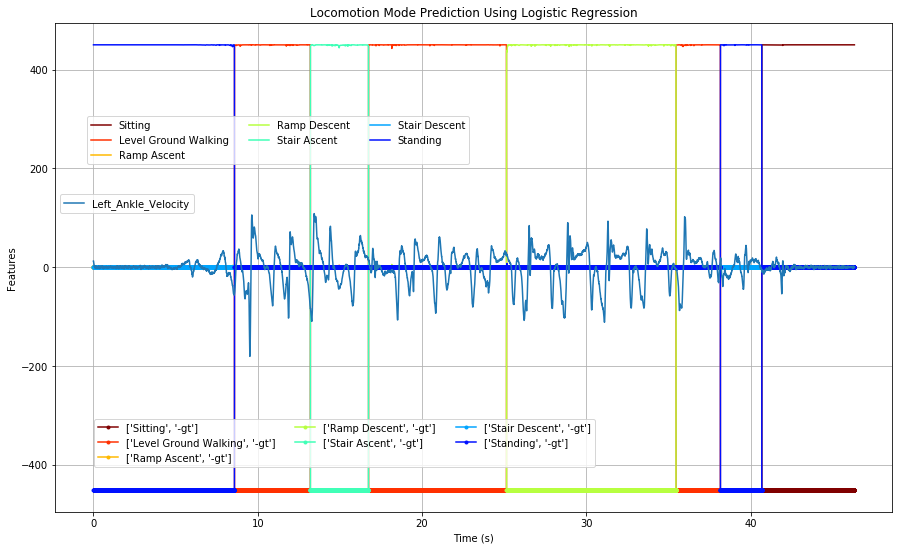

In [20]:
#%%
preds = lr_model2.predict(array_data_in_notrigger_float)
labelcategories = ['Sitting','Level Ground Walking','Ramp Ascent','Ramp Descent','Stair Ascent','Stair Descent','Standing']
#print(preds)
plt.figure(figsize=(15, 9))
cmap = plt.get_cmap('jet_r')
labelpreds0, = plt.plot(t, preds[:, 0]*450, label=labelcategories[0], color = cmap(0/len(labelcategories)))
labelpreds1, = plt.plot(t, preds[:, 1]*450, label=labelcategories[1], color = cmap(1/len(labelcategories)))
labelpreds2, = plt.plot(t, preds[:, 2]*450, label=labelcategories[2], color = cmap(2/len(labelcategories)))
labelpreds3, = plt.plot(t, preds[:, 3]*450, label=labelcategories[3], color = cmap(3/len(labelcategories)))
labelpreds4, = plt.plot(t, preds[:, 4]*450, label=labelcategories[4], color = cmap(4/len(labelcategories)))
labelpreds5, = plt.plot(t, preds[:, 5]*450, label=labelcategories[5], color = cmap(5/len(labelcategories)))
labelpreds6, = plt.plot(t, preds[:, 6]*450, label=labelcategories[6], color = cmap(6/len(labelcategories)))
labelgt0, = plt.plot(t, label_prep[:, 0]*(-450),marker='.', label=[labelcategories[0],'-gt'], color = cmap(0/len(labelcategories)))
labelgt1, = plt.plot(t, label_prep[:, 1]*(-450),marker='.', label=[labelcategories[1],'-gt'], color = cmap(1/len(labelcategories)))
labelgt2, = plt.plot(t, label_prep[:, 2]*(-450),marker='.', label=[labelcategories[2],'-gt'], color = cmap(2/len(labelcategories)))
labelgt3, = plt.plot(t, label_prep[:, 3]*(-450),marker='.', label=[labelcategories[3],'-gt'], color = cmap(3/len(labelcategories)))
labelgt4, = plt.plot(t, label_prep[:, 4]*(-450),marker='.', label=[labelcategories[4],'-gt'], color = cmap(4/len(labelcategories)))
labelgt5, = plt.plot(t, label_prep[:, 5]*(-450),marker='.', label=[labelcategories[5],'-gt'], color = cmap(5/len(labelcategories)))
labelgt6, = plt.plot(t, label_prep[:, 6]*(-450),marker='.', label=[labelcategories[6],'-gt'], color = cmap(6/len(labelcategories)))

firstlegend = plt.legend(handles=[labelpreds0,labelpreds1,labelpreds2,labelpreds3,labelpreds4,labelpreds5,labelpreds6],
                         bbox_to_anchor=(0.5,0.7),ncol=3)
ax = plt.gca().add_artist(firstlegend)
secondlegend = plt.legend(handles=[labelgt0,labelgt1, labelgt2, labelgt3, labelgt4, labelgt5, labelgt6],
                          bbox_to_anchor=(0.65,0.2),ncol=3)
ax = plt.gca().add_artist(secondlegend)
#labelpreds, = plt.plot(t, label_prep*4)
data1, = plt.plot(t, array_data_in_notrigger_float[:,-2-1], label=categories[-2-1-8])
#plt.plot(t, array_data_in_notrigger_float[:,1], label=categories[1])
#plt.plot(t, array_data_in_notrigger_float[:,2], label=categories[2])
plt.legend(handles=[data1],bbox_to_anchor=(0,0.6,1, 0.4) )
#plt.xlim([26, 46])
#plt.ylim([-50, 50])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.title('Locomotion Mode Prediction Using Logistic Regression')
plt.grid()
plt.show()

In [29]:
import os
os.getcwd()

'C:\\Users\\Zed_Luz\\OneDrive\\3-MEE\\21-NUS Lab Intern\\Work\\3-IMU-DeepLearning\\Zeyu\\1-Python Files'